In [1]:
# import 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle

### Load Models

In [2]:
# infer_RHNH = keras.models.load_model('../../Weights/helmet_no_helmet_512')
infer_RHNH = keras.models.load_model('../Weights/yolov4/helmet_no_helmet_ROI')
infer_rider_motor = keras.models.load_model('../Weights/yolov4/rider_motor_512')
trapez_model = pickle.load(open('../Weights/trapezium_regressor/Trapezium_Prediction_Weights.pickle', 'rb'))

c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Load Images from Validation Set

In [3]:
import os

frames = []
frames2 = []

# Storing all the Validation Images 
# Images are all files with .jpg in data/validation_data_234Images

for file in os.listdir('../data/validation_data_234Images/M_R_H_NH/'):
    if file.endswith('.jpg'):
        # read the image and storing 2 copies of it for annotation purposes 
        img1 = cv2.imread(os.path.join('../data/validation_data_234Images/M_R_H_NH/', file))
        img2 = img1.copy()
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        frames.append(img1)
        frames2.append(img2)

No of Images 4
			Random Images from Validation Data


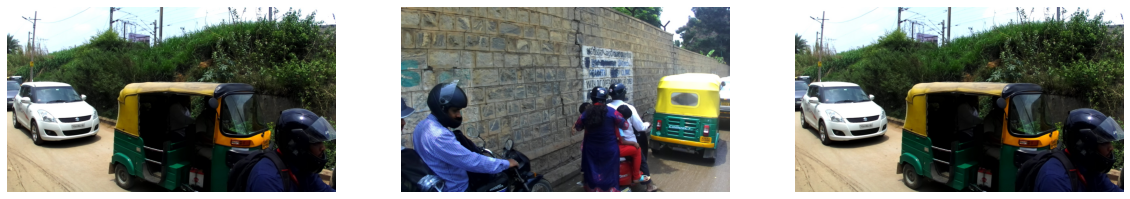

In [4]:
# # limit to first 10 images
frames = frames[:4]
frames2 = frames2[:4]

print("No of Images", len(frames))
# Print 3 random images in a single row
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
print('\t\t\tRandom Images from Validation Data')
random_indices = np.random.randint(0, len(frames), 3)
for i, idx in enumerate(random_indices):
    ax[i].imshow(frames[idx])
    ax[i].axis('off')
plt.show()

### Prepare Image input for Model

In [5]:
input_size = 512
all_batch_data = []
for i, frame in enumerate(frames):
    frame_size = frame.shape[:2]
    image_data = cv2.resize(frame, (input_size, input_size))
    image_data = image_data / 255.
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    batch_data = tf.constant(image_data)
    all_batch_data.append(batch_data)

### R + M Model Prediction

In [6]:
all_rider_motor_bbox = []

for batch_data in all_batch_data:
    rider_motor_bbox = infer_rider_motor.predict(batch_data)
    all_rider_motor_bbox.append(rider_motor_bbox)

1/1 [==============================] - 1s 1s/step


In [7]:
iou = 0.45
score = 0.50

allowed_classes = [0,1]

# This stores the rider & motorcycle boxes, scores, classes and number of objects detected for each image in the validation set
all_boxes_R_M = []
all_scores_R_M = []
all_classes_R_M = []
all_num_objects_R_M = []

for rider_motor_bbox in all_rider_motor_bbox:
    for value in rider_motor_bbox:
        temp_value = np.expand_dims(value, axis=0)
        boxes_R_M = temp_value[:, :, 0:4]
        pred_conf = temp_value[:, :, 4:]

    boxes_R_M, scores_R_M, classes_R_M, valid_detections_R_M = tf.image.combined_non_max_suppression(
                boxes=tf.reshape(boxes_R_M, (tf.shape(boxes_R_M)[0], -1, 1, 4)),
                scores=tf.reshape(
                    pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
                max_output_size_per_class=50,
                max_total_size=50,
                iou_threshold=iou,
                score_threshold=score
            )
    num_objects_R_M = valid_detections_R_M.numpy()[0]
    boxes_R_M = boxes_R_M.numpy()[0]
    boxes_R_M = boxes_R_M[0:int(num_objects_R_M)]
    scores_R_M = scores_R_M.numpy()[0]
    scores_R_M = scores_R_M[0:int(num_objects_R_M)]
    classes_R_M = classes_R_M.numpy()[0]
    classes_R_M = classes_R_M[0:int(num_objects_R_M)]

    deleted_indx = []
    for i in range(num_objects_R_M):
        class_indx = int(classes_R_M[i])
        if class_indx not in allowed_classes:
            deleted_indx.append(i)
    boxes_R_M = np.delete(boxes_R_M, deleted_indx, axis=0)
    scores_R_M = np.delete(scores_R_M, deleted_indx, axis=0)
    classes_R_M = np.delete(classes_R_M, deleted_indx, axis=0)
    num_objects_R_M = len(classes_R_M)

    # MOTORCYCLE CLASS CHANGED TO 3 FROM 1
    classes_R_M[classes_R_M == 1] = 3

    all_boxes_R_M.append(boxes_R_M)
    all_scores_R_M.append(scores_R_M)
    all_classes_R_M.append(classes_R_M)
    all_num_objects_R_M.append(num_objects_R_M)

In [8]:
import pandas as pd

# This stores the rider and motorcycle dataframes for each image in the validation set
all_rider = []
all_motorcycle = []

# Getting the rider motorcycle dataframe 

for i, frame in enumerate(frames):
    # Bounding boxes are in normalized ymin, xmin, ymax, xmax
    original_h, original_w, _ = frame.shape
    classes_R_M = all_classes_R_M[i]
    boxes_R_M = all_boxes_R_M[i]

    #getting rider, motorcycle dataframe
    df = pd.DataFrame(classes_R_M, columns=['class_id'])
    ymin = boxes_R_M[:, 0]
    xmin = boxes_R_M[:, 1]
    ymax = boxes_R_M[:, 2]
    xmax = boxes_R_M[:, 3]
    df['x'] = pd.DataFrame(xmin + (xmax-xmin)/2, columns=['x'])
    df['y'] = pd.DataFrame(ymin + (ymax-ymin)/2, columns=['y'])
    df['w'] = pd.DataFrame(xmax-xmin, columns=['w'])
    df['h'] = pd.DataFrame(ymax-ymin, columns=['h'])
    rider = df.loc[df['class_id']==0]
    motorcycle = df.loc[df['class_id']==3]
    all_rider.append(rider)
    all_motorcycle.append(motorcycle)

### Assigning same Instance Ids to riders of a corresponding motorcycle

In [9]:
# assign instance id to each rider AND motorcycle
import sys
sys.path.append('../')
from core.association import motor_rider_iou, motor2_rider_iou

def get_instance(rider, motorcycle, iou_threshold):
    """
    args:
    rider, motorcycle : pd.DataFrame

    output:
    rider, motorycle : pd.DataFrame with a column named 'instance_id'
    """
    rider['instance_id'] = -1
    motorcycle['instance_id'] = -1
    
    for i in range(len(motorcycle)):
        motorcycle.iat[i,motorcycle.columns.get_loc('instance_id')] = i
        for j in range(len(rider)):
            if (motor_rider_iou(motorcycle.iloc[i], rider.iloc[j]) > iou_threshold):
                if (rider.iloc[j]['instance_id'] == -1):
                    rider.iat[j,rider.columns.get_loc('instance_id')] = i
                else:
                    instance = int(rider.iloc[j]['instance_id'])
                    instance_final = motor2_rider_iou(motorcycle.iloc[i], motorcycle.iloc[instance], rider.iloc[j], i, instance)
                    rider.iat[j,rider.columns.get_loc('instance_id')] = instance_final
    return rider, motorcycle

for i in range(len(all_rider)):
    all_rider[i], all_motorcycle[i] = get_instance(all_rider[i], all_motorcycle[i], 0.01)
    # print("\n\nRider and Motorcycle Dataframe for image ", i)
    # print(all_rider[i])
    # print(all_motorcycle[i])

c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\basur\AppData\Local\Temp\ipykernel_18040\2753611414.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider['instance_id'] = -1
C:\Users\basur\AppData\Local\Temp\ipykernel_18040\2753611414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motorcycle['instance_id'] = -1
c:\Users\basur\AppData\

### Extracting ROIs from Images

In [10]:
def extract_roi(frame, rider, motorcycle) :
    """
    args:
    frame : np.array
    rider, motorcycle : pd.DataFrame

    output:
    roi_instances : list of np.array
    """
    roi_instances = []
    for i in range(len(motorcycle)):
        motor = motorcycle.loc[motorcycle['instance_id']==i]
        instance = motorcycle.iloc[i]['instance_id']
        ride = rider.loc[rider['instance_id']== instance]

        if (len(ride)==0):
            continue
        
        xmax = max(float(motor['x'] + motor['w']/2), max(ride['x'] + ride['w']/2))
        xmin = min(float(motor['x'] - motor['w']/2), min(ride['x'] - ride['w']/2))
        ymax = max(float(motor['y'] + motor['h']/2), max(ride['y'] + ride['h']/2))
        ymin = min(float(motor['y'] - motor['h']/2), min(ride['y'] - ride['h']/2))

        w = xmax - xmin
        h = ymax - ymin

        xmax = xmax + 0.05*w
        xmin = xmin - 0.05*w

        ymax = ymax + 0.05 * h
        ymin = ymin - 0.05 * h

        if (xmin < 0):
            xmin=0
        if (xmax >1):
            xmax=1
        if (ymax>1):
            ymax =1
        if(ymin<0):
            ymin =0

        t = int(ymin*frame.shape[0])
        l = int(xmin*frame.shape[1])
        b = int(ymax*frame.shape[0])
        r = int(xmax*frame.shape[1])

        if t<0 or l<0 or b<0 or r<0:
            continue
        roi_frame = frame[t:b, l:r]
        # roi_frame = frame
        original_position = (t,l,b,r)
        roi_dict = {'frame':roi_frame, 'original_position':original_position}
        roi_instances.append(roi_dict)

    return roi_instances

# Stores all rois in outputs/roi_images folder
all_roi_instances = []
for i in range(len(frames)):
    roi_instances = extract_roi(frames[i], all_rider[i], all_motorcycle[i])
    for j, roi_instance in enumerate(roi_instances):
        # convert to BGR
        roi_instance['frame'] = cv2.cvtColor(roi_instance['frame'], cv2.COLOR_RGB2BGR)
        cv2.imwrite("outputs/roi_images/roi_image_" + str(i) + "_" + str(j) + ".jpg", roi_instance['frame'])
        roi_instance['frame'] = cv2.cvtColor(roi_instance['frame'], cv2.COLOR_BGR2RGB)
    all_roi_instances.append(roi_instances)

## Helmet / No Helmet Detection (ROI Based)

In [11]:
# The following code loops through all the frames in the first loop. For each frame, via a series of nested loops, the helmet / no-helmet classifier is run on each ROI in the frame.
# The bounding boxes for each ROI are then extrapolated back to the original frame size and stored in a list. The same is done for the class and score of each ROI.


# The following would be the output of ROI based detection for a single frame
all_frames_boxes_HNH = []
all_frames_classes_HNH = []
all_frames_scores_HNH = []
all_frames_num_objects_HNH = []
all_frames_ROI_sizes = []

for image_idx in range(len(all_roi_instances)):
    # roi instances for a single image
    roi_instances = all_roi_instances[image_idx]

    all_batch_data = []
    frame_size_ROI = []
    for i in range(len(roi_instances)):
        instance_frame = roi_instances[i]['frame']
        frame_size_ROI.append(instance_frame.shape)
        image_data = cv2.resize(instance_frame, (input_size, input_size))
        image_data = image_data / 255.
        image_data = image_data[np.newaxis, ...].astype(np.float32)
        batch_data = tf.constant(image_data)
        all_batch_data.append(batch_data)

    # Getting helmet / no-helmet predictions
    all_instance_H_NH_boxes = []

    for i in range(len(all_batch_data)):
        batch_data = all_batch_data[i]
        H_NH_boxes = infer_RHNH.predict(batch_data)
        all_instance_H_NH_boxes.append(H_NH_boxes)

    all_final_HNH_boxes = []
    all_pred_conf_HNH = []
    for i in range(len(all_instance_H_NH_boxes)):
        single_instance_boxes = all_instance_H_NH_boxes[i]
        for value in single_instance_boxes:
            temp_value = np.expand_dims(value, axis=0)
            boxes = temp_value[:, :, 0:4]
            conf = temp_value[:, :, 4:]
        all_final_HNH_boxes.append(boxes)
        all_pred_conf_HNH.append(conf)


    # NMS

    all_bboxes_HNH = []
    all_scores_HNH = []
    all_classes_HNH = []
    all_num_objects_HNH = []

    for i in range(len(all_final_HNH_boxes)):
        boxes = all_final_HNH_boxes[i]
        conf = all_pred_conf_HNH[i]
        boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
            scores=tf.reshape(conf, (tf.shape(conf)[0], -1, tf.shape(conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=0.45,
            score_threshold=0.5
        )

        num_objects_HNH = valid_detections.numpy()[0]
        bboxes_HNH = boxes.numpy()[0]
        bboxes_HNH = bboxes_HNH[0:int(num_objects_HNH)]
        scores_HNH = scores.numpy()[0]
        scores_HNH = scores_HNH[0:int(num_objects_HNH)]
        classes_HNH = classes.numpy()[0]
        classes_HNH = classes_HNH[0:int(num_objects_HNH)]

        deleted_indx = []
        allowed_classes = [0, 1]
        for i in range(num_objects_HNH):
            class_indx = int(classes_HNH[i])
            if class_indx not in allowed_classes:
                deleted_indx.append(i)
        bboxes_HNH = np.delete(bboxes_HNH, deleted_indx, axis=0)
        scores_HNH = np.delete(scores_HNH, deleted_indx, axis=0)
        classes_HNH = np.delete(classes_HNH, deleted_indx, axis=0)
        num_objects_HNH = len(classes_HNH)

        classes_HNH[classes_HNH == 1] = 2
        classes_HNH[classes_HNH == 0] = 1

        all_bboxes_HNH.append(bboxes_HNH)
        all_scores_HNH.append(scores_HNH)
        all_classes_HNH.append(classes_HNH)
        all_num_objects_HNH.append(num_objects_HNH)

    # This will store the final bounding boxes, scores and classes for the image (Helmet / No Helmet)
    final_bboxes_HNH = []
    final_scores_HNH = []
    final_classes_HNH = []
    final_num_objects_HNH = 0

    # convert the bounding box to the original image in yolo format and store it in final_bboxes_HNH
    for i in range(len(roi_instances)):
        original_position = roi_instances[i]['original_position']
        full_frame_width = frames[image_idx].shape[1]
        full_frame_height = frames[image_idx].shape[0]
        for j in range(all_num_objects_HNH[i]):
            xmin = int(all_bboxes_HNH[i][j][1] * frame_size_ROI[i][1])
            ymin = int(all_bboxes_HNH[i][j][0] * frame_size_ROI[i][0])
            xmax = int(all_bboxes_HNH[i][j][3] * frame_size_ROI[i][1])
            ymax = int(all_bboxes_HNH[i][j][2] * frame_size_ROI[i][0])
            xmin = xmin + original_position[1]
            xmax = xmax + original_position[1]
            ymin = ymin + original_position[0]
            ymax = ymax + original_position[0]
            
            # convert to yolo format 
            x_center = (xmin + xmax) / (2 * full_frame_width)
            y_center = (ymin + ymax) / (2 * full_frame_height)
            width = (xmax - xmin) / full_frame_width
            height = (ymax - ymin) / full_frame_height
            final_bboxes_HNH.append([x_center, y_center, width, height])
            final_scores_HNH.append(all_scores_HNH[i][j])
            final_classes_HNH.append(all_classes_HNH[i][j])
            final_num_objects_HNH += 1

    all_frames_boxes_HNH.append(final_bboxes_HNH)
    all_frames_scores_HNH.append(final_scores_HNH)
    all_frames_classes_HNH.append(final_classes_HNH)
    all_frames_num_objects_HNH.append(final_num_objects_HNH)
    all_frames_ROI_sizes.append(frame_size_ROI)
    print("Done with image: ", image_idx)


1/1 [==============================] - 1s 1s/step
Done with image:  0
1/1 [==============================] - 1s 1s/step
Done with image:  1
Done with image:  2
1/1 [==============================] - 2s 2s/step
Done with image:  3


### R+M predicted boxes annotated on Images stored in outpts folder

In [12]:
# plot rider and motorcycle bounding boxes

for image_idx in range(len(frames2)):
    frame = frames2[image_idx]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    rider = all_rider[image_idx]
    motorcycle = all_motorcycle[image_idx]
    for motor in motorcycle.iterrows():
        xmin = motor[1]['x'] - motor[1]['w']/2
        ymin = motor[1]['y'] - motor[1]['h']/2
        xmax = motor[1]['x'] + motor[1]['w']/2
        ymax = motor[1]['y'] + motor[1]['h']/2
        xmin = int(xmin*original_w)
        ymin = int(ymin*original_h)
        xmax = int(xmax*original_w)
        ymax = int(ymax*original_h)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 5)
        cv2.putText(frame, 'motorcycle', (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (12,255,36), 5)

    for ride in rider.iterrows():
        xmin = ride[1]['x'] - ride[1]['w']/2
        ymin = ride[1]['y'] - ride[1]['h']/2
        xmax = ride[1]['x'] + ride[1]['w']/2
        ymax = ride[1]['y'] + ride[1]['h']/2
        xmin = int(xmin*original_w)
        ymin = int(ymin*original_h)
        xmax = int(xmax*original_w)
        ymax = int(ymax*original_h)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,255,0), 5)
        cv2.putText(frame, 'rider', (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (12,255,36), 5)     
    
    # save in folder 
    cv2.imwrite('outputs/annotated_R_M/' + str(image_idx) + '.jpg', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

### Helmet / No Helmet Annotated Images stored in outputs folder

In [13]:
# show the bounding box and the label for each image in outputs/annotated_HNH
for image_idx in range(len(all_frames_boxes_HNH)):
    frame = frames[image_idx]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    final_bboxes_HNH = all_frames_boxes_HNH[image_idx]
    final_scores_HNH = all_frames_scores_HNH[image_idx]
    final_classes_HNH = all_frames_classes_HNH[image_idx]
    for i in range(all_frames_num_objects_HNH[image_idx]):
        xmin = int((final_bboxes_HNH[i][0] - final_bboxes_HNH[i][2] / 2) * frame.shape[1])
        ymin = int((final_bboxes_HNH[i][1] - final_bboxes_HNH[i][3] / 2) * frame.shape[0])
        xmax = int((final_bboxes_HNH[i][0] + final_bboxes_HNH[i][2] / 2) * frame.shape[1])
        ymax = int((final_bboxes_HNH[i][1] + final_bboxes_HNH[i][3] / 2) * frame.shape[0])
        if final_classes_HNH[i] == 1:
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 7)
        else :
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 7)
        cv2.putText(frame, '{} {:.2f}'.format(int(final_classes_HNH[i]), final_scores_HNH[i]),
                    (xmin, ymin - 5), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 7)
    cv2.imwrite('outputs/annotated_HNH/' + str(image_idx) + '.jpg', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print("Done with image: ", image_idx)

Done with image:  0
Done with image:  1
Done with image:  2
Done with image:  3


## Trapezium Detection & Triple Riding Detection

In [14]:
## Helper Functions

def heuristic_on_pred(a, motor, rider_ins):
    no_of_bbox = len(motor) + len(rider_ins)
    if (motor['w']==0):
        no_of_bbox = no_of_bbox - 1

    mean_w = (rider_ins['w'].sum() + motor['w'].sum())/no_of_bbox
    mean_x = (rider_ins['x'].sum() + motor['x'].sum())/no_of_bbox

    if (a[4]<mean_w):
        a[4] = motor['w'].mean()
    if (a[0] < mean_x - mean_w/2):
        a[0] = rider_ins['x'].mean()
    if (a[0] > mean_x + mean_w/2):
        a[0] = rider_ins['x'].mean()
    return a

def corner_condition(y, xmax, ymax):
    if (y[0]<0):
        y[0] = 0
    if (y[0]>xmax):
        y[0] = xmax
    if (y[1]<0):
        y[1] = 0
    if (y[1]>ymax):
        y[1] = ymax
    if (y[2]<0):
        y[2] = 0
    if (y[2]>xmax):
        y[2] = xmax
    if (y[3]<0):
        y[3] = 0
    if (y[3]>ymax):
        y[3] = ymax
    if (y[4]<0):
        y[4] = 0
    if (y[4]>xmax):
        y[4] = xmax
    if (y[5]<0):
        y[5] = 0
    if (y[5]>ymax):
        y[5] = ymax
    if (y[6]<0):
        y[6] = 0
    if (y[6]>xmax):
        y[6] = xmax
    if (y[7]<0):
        y[7] = 0
    if (y[7]>ymax):
        y[7] = ymax
    
    return y

### Using Trapezium Regressor Model

In [15]:
all_frames_trap_boxes = []

for image_idx in range(len(frames)):
    motorcycle = all_motorcycle[image_idx]
    rider = all_rider[image_idx]
    trapezium_boxes = np.zeros((len(motorcycle), 8))
    trapezium_idx = 0
    for i in range(len(motorcycle)):
        input = []
        motor = motorcycle.iloc[i]
        instance = motor['instance_id']
        input.extend([float (motor['x']),float (motor['y']),float (motor['w']),float (motor['h'])])

        rider_ins = rider.loc[rider['instance_id']==instance]
            
        for j in range(len(rider_ins)):
            input.extend([float (rider_ins.iloc[j]['x']),float (rider_ins.iloc[j]['y']),float (rider_ins.iloc[j]['w']),float (rider_ins.iloc[j]['h'])])
        
        x=np.zeros((1,24))
        x[0,:len(input)] = np.array(input).reshape((1,-1))
        predict = trapez_model.predict(x)
 
        a = predict[0]
        a = heuristic_on_pred(a, motor, rider_ins)
        trapezium_boxes[trapezium_idx][0], trapezium_boxes[trapezium_idx][1], trapezium_boxes[trapezium_idx][2], trapezium_boxes[trapezium_idx][3], trapezium_boxes[trapezium_idx][4], trapezium_boxes[trapezium_idx][5],trapezium_boxes[trapezium_idx][6] ,trapezium_boxes[trapezium_idx][7]  = (a[0] - a[4]/2)*original_w,(a[5]+x[0][1]-x[0][3]/2)*original_h, (a[0] - a[4]/2)*original_w,(a[2]+x[0][1]+x[0][3]/2)*original_h, (a[0] + a[4]/2)*original_w, (a[3]+x[0][1]+x[0][3]/2)*original_h, (a[0] + a[4]/2)*original_w, (a[6]+x[0][1]-x[0][3]/2)*original_h
        
        trapezium_boxes[trapezium_idx] = corner_condition(trapezium_boxes[trapezium_idx], original_w, original_h)
        trapezium_idx = trapezium_idx+1
            
    trapezium_boxes = trapezium_boxes[:trapezium_idx,:]
    trapezium_boxes = trapezium_boxes.astype(int)

    all_frames_trap_boxes.append(trapezium_boxes)


### IOU based counting of riders

In [16]:
from core.association import iou

def trapez_rider_iou(y_, rider):

    y_ = [[y_[0], y_[1]], [y_[2], y_[3]], [y_[4], y_[5]], [y_[6], y_[7]]]
    x, y, w, h = rider['x'], rider['y'], rider['w'], rider['h']
    rider = [[x-w/2, y-h/2], [x+w/2, y-h/2], [x+w/2, y+h/2], [x-w/2, y+h/2]]

    return iou(y_, rider)

def get_instance_with_trapez(rider, trapezium, iou_threshold):
    """
    args:
    rider, trapezium : pd.DataFrame

    output:
    rider, trapezium : pd.DataFrame with a column named 'instance_id'
    """
    # print info of the rider and trapezium dataframes
    # print("Rider dataframe info:")
    # print(rider.info())
    trapezium_instance_ids = np.zeros(len(trapezium))
    for i in range(len(trapezium)):
        trapezium_instance_ids[i] = i
        for j in range(len(rider)):
            if (trapez_rider_iou(trapezium[i], rider.iloc[j]) > iou_threshold):
                if (rider.iloc[j]['instance_id'] == -1):
                    rider.iat[j,rider.columns.get_loc('instance_id')] = i
                else:
                    instance = int(rider.iloc[j]['instance_id'])
                    if (trapez_rider_iou(trapezium[instance], rider.iloc[j]) < trapez_rider_iou(trapezium[i], rider.iloc[j])):
                        rider.iat[j,rider.columns.get_loc('instance_id')] = i
                    else:
                        rider.iat[j,rider.columns.get_loc('instance_id')] = instance
    return rider, trapezium_instance_ids

In [17]:
all_frames_trap_classes = []

for image_idx in range(len(frames)):
    rider, trapez_instance_ids = get_instance_with_trapez(all_rider[image_idx], all_frames_trap_boxes[image_idx], 0.01)
    trapezium_classes = np.zeros(len(all_frames_trap_boxes[image_idx]))
    # The class of a trapezium is 0 if there are less than 3 riders in it, or else 1
    for i in range(len(all_frames_trap_boxes[image_idx])):
        trapezium_classes[i] = len(rider.loc[rider['instance_id']==i])
        if (trapezium_classes[i] >= 3):
            trapezium_classes[i] = 1
        else :
            trapezium_classes[i] = 0
    all_frames_trap_classes.append(trapezium_classes)

c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


### Storing annotated Trapezium images in outputs folder

In [18]:
# store the images with annotated trapezium boxes | Dark Orange : 1 (triple riding violation), Cyan : 0
# stored in outputs/annotated_triple_riding_violation
for image_idx in range(len(frames)):
    trapezium_boxes = all_frames_trap_boxes[image_idx]
    trapezium_classes = all_frames_trap_classes[image_idx]
    frame = frames2[image_idx]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    for i in range(len(trapezium_boxes)):
        pts = np.array([[trapezium_boxes[i][0],trapezium_boxes[i][1]],[trapezium_boxes[i][2],trapezium_boxes[i][3]],[trapezium_boxes[i][4],trapezium_boxes[i][5]],[trapezium_boxes[i][6],trapezium_boxes[i][7]]], np.int32)
        pts = pts.reshape((-1,1,2))
        if (trapezium_classes[i] == 0):
            frame = cv2.polylines(frame,[pts],True,(255,255,0),5)
        else:
            frame =cv2.polylines(frame,[pts],True,(71,99,255),5)
    cv2.imwrite('outputs/annotated_triple_riding_violation/'+str(image_idx)+'.jpg', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


In [19]:
triple_riding_violation = []

for image_idx in range(len(frames)):
    trapezium_classes = all_frames_trap_classes[image_idx]
    for i in range(len(trapezium_classes)):
        if (trapezium_classes[i] == 1):
            triple_riding_violation.append([image_idx, i])

print("Number of triple riding violation instances: ", len(triple_riding_violation))


Number of triple riding violation instances:  1


## Getting ground truth annotations

In [20]:
# Get the ground truth annotations from txt files in data/validation_data_234Images

# Contains the class id (0/1/2/3) and bounding box coordinates of all instances in all frames
ground_truth_annotations_all_frames = []

    
for file in os.listdir('../data/validation_data_234Images/M_R_H_NH/'):
    if file.endswith(".txt"):
        frame_ground_truth_annotations = []
        file_name = file.split('.')[0]     
        f = open('../data/validation_data_234Images/M_R_H_NH/'+file, 'r')
        lines = f.readlines()
        for line in lines:
            line = line.split()
            class_id = int(line[0])
            boxes = [float(line[1]), float(line[2]),
                        float(line[3]), float(line[4])]
            annotation = {'class_id': class_id, 'boxes': boxes}
            frame_ground_truth_annotations.append(annotation)
        ground_truth_annotations_all_frames.append(frame_ground_truth_annotations)

print("Number of frames with ground truth annotations: ", len(ground_truth_annotations_all_frames))


Number of frames with ground truth annotations:  234


In [21]:
# get 4 class MAP given the ground truth annotations and the predicted bounding boxes, scores and classes in yolo format
# the ground truth annotations are in the format: [class, x, y, w, h]
# the predicted bounding boxes are in the format: [x, y, w, h, score, class]
# the classes are : 0,1,2,3
# the scores are between 0 and 1
# the MAP is calculated for each class and then averaged over the 4 classes






In [22]:
# # getting iou of all predicted instances with ground truth annotations
# # returns a list of dictionaries, each dictionary contains the iou of a predicted instance with all ground truth annotations
# # the dictionary also contains the ground truth annotation with which the iou is maximum
# def get_iou_with_ground_truth(ground_truth_annotations, predicted_instances, iou_threshold=0.5):
#     iou_with_ground_truth = []
#     for pred_idx in range(len(predicted_instances)):
#         current_ious = []
#         for j in range(len(ground_truth_annotations)):
#             if int(ground_truth_annotations[j]['class_id']) == int(predicted_instances.iloc[pred_idx]['class_id']):
#                 gt = {}
#                 gt['x'] = ground_truth_annotations[j]['boxes'][0]
#                 gt['y'] = ground_truth_annotations[j]['boxes'][1]
#                 gt['w'] = ground_truth_annotations[j]['boxes'][2]
#                 gt['h'] = ground_truth_annotations[j]['boxes'][3]
#                 iou = motor_rider_iou(predicted_instances.iloc[pred_idx], gt)
#                 if iou > iou_threshold:
#                     current_ious.append(motor_rider_iou(predicted_instances.iloc[pred_idx], gt))
#                 else : current_ious.append(0)
#             else : current_ious.append(0)
#         if len(current_ious) == 0:
#             iou_with_ground_truth.append({'iou': 0, 'ground_truth_annotation': None})
#             continue
#         max_iou = max(current_ious)
#         max_iou_idx = current_ious.index(max_iou)
#         iou_with_ground_truth.append({'iou': max_iou, 'ground_truth_annotation': ground_truth_annotations[max_iou_idx]})
#     return iou_with_ground_truth

# all_rider_iou_gt = []
# all_motorcycle_iou_gt = []
# all_helmet_iou_gt = []
# all_no_helmet_iou_gt = []


# all_helmet = []
# all_no_helmet = []

# for i in range(len(all_frames_boxes_HNH)):
#     helmet = [all_frames_boxes_HNH[i][j] for j in range(len(all_frames_boxes_HNH[i])) if all_frames_classes_HNH[i][j] == 1]
#     no_helmet = [all_frames_boxes_HNH[i][j] for j in range(len(all_frames_boxes_HNH[i])) if all_frames_classes_HNH[i][j] == 0]
#     # create a dataframe with x, y, w, h where each entry is each item of helmet
#     helmet_df = pd.DataFrame(helmet, columns=['x', 'y', 'w', 'h'])
#     no_helmet_df = pd.DataFrame(no_helmet, columns=['x', 'y', 'w', 'h'])
#     # add class_id column to the dataframe
#     helmet_df['class_id'] = 1
#     no_helmet_df['class_id'] = 2
#     all_helmet.append(helmet_df)
#     all_no_helmet.append(no_helmet_df)

# for image_idx in range(len(frames)):
#     rider_iou_gt = get_iou_with_ground_truth(ground_truth_annotations_all_frames[image_idx], all_rider[image_idx])
#     motorcycle_iou_gt = get_iou_with_ground_truth(ground_truth_annotations_all_frames[image_idx], all_motorcycle[image_idx])
#     helmet_iou_gt = get_iou_with_ground_truth(ground_truth_annotations_all_frames[image_idx], all_helmet[image_idx])
#     no_helmet_iou_gt = get_iou_with_ground_truth(ground_truth_annotations_all_frames[image_idx], all_no_helmet[image_idx])
#     all_rider_iou_gt.append(rider_iou_gt)
#     all_motorcycle_iou_gt.append(motorcycle_iou_gt)
#     all_helmet_iou_gt.append(helmet_iou_gt)
#     all_no_helmet_iou_gt.append(no_helmet_iou_gt)


In [23]:
print(all_helmet[0])
print(all_no_helmet[0])

print(all_helmet_iou_gt[0])
print(all_no_helmet_iou_gt[0])

NameError: name 'all_helmet' is not defined

In [ ]:
### CALCULATION OF TRUE POSITIVES, FALSE POSITIVES, FALSE NEGATIVES .... LEFT